# Fixed-point iteration

In this tutorial, we will solve the homogenization problem using Moulinec-Suquet's fixed-point iteration scheme.

In [ ]:
import jax

jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import time
from functools import partial

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array

from xpektra import (
    SpectralSpace,
    make_field,
)
from xpektra.projection_operator import MoulinecSuquetProjection
from xpektra.scheme import FourierScheme
from xpektra.spectral_operator import SpectralOperator
from xpektra.transform import FFTTransform

Let us start by defining the RVE geometry. We will consider a 2D square RVE with a circular inclusion.

In [ ]:
N = 251
ndim = 2
length = 1

In [ ]:
# Create phase indicator (cylinder)
x = np.linspace(-0.5, 0.5, N)

if ndim == 3:
    Y, X, Z = np.meshgrid(x, x, x, indexing="ij")  # (N, N, N) grid
    phase = jnp.where(X**2 + Z**2 <= (0.2 / np.pi), 1.0, 0.0)  # 20% vol frac
else:
    X, Y = np.meshgrid(x, x, indexing="ij")  # (N, N) grid
    phase = jnp.where(X**2 + Y**2 <= (0.2 / np.pi), 1.0, 0.0)

## Define the material parameters

We consider a two-phase material with the following material parameters:

The first Lamé parameter is $\lambda_1 = 10.0$ and the second is $\lambda_2 = 100.0$ and shear moduli are $\mu_1 = 0.25, \mu_2 = 2.5$



In [ ]:
# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 10.0, 100.0
mu1, mu2 = 0.25, 2.5
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase

In [4]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(lengths=(length, length), shape=(N, N), transform=fft_transform)

diff_scheme = FourierScheme(space=space)

op = SpectralOperator(
    scheme=diff_scheme,
    space=space,
)

In [5]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=(N, N), rank=2) + i  # Add i to broadcast

I4 = jnp.einsum("il,jk->ijkl", i, i)
I4rt = jnp.einsum("ik,jl->ijkl", i, i)
I4s = (I4 + I4rt) / 2.0
II = jnp.einsum("...ij,...kl->...ijkl", I, I)

# Broadcast scalars to the 4th-order tensor shape
C4 = (
    lambdas[..., None, None, None, None] * II
    + (2.0 * mu[..., None, None, None, None]) * I4s
)

# Use average properties for the reference material
lambda0 = (lambda1 + lambda2) / 2.0
mu0 = (mu1 + mu2) / 2.0

# Build the constant C0 reference tensor [shape (3,3,3,3)]
C0 = lambda0 * II + 2.0 * mu0 * I4s

In [6]:
Ghat = MoulinecSuquetProjection(
    space=space, lambda0=lambda0, mu0=mu0
).compute_operator()

In [7]:
@partial(jax.jit, static_argnames=["max_iter", "tol"])
def fixed_point_iteration(
    E_macro: Array, eps_guess: Array, max_iter: int, tol: float
) -> Array:
    """Solves the Lippmann-Schwinger equation via fixed-point iteration."""

    eps = eps_guess

    def cond_fun(state):
        eps_k, eps_prev, k = state
        err = jnp.linalg.norm(eps_k - eps_prev) / jnp.linalg.norm(E_macro)
        jax.debug.print("Error: {err}", err=err)
        return jnp.logical_and(err > tol, k < max_iter)

    def body_fun(state):
        eps_k, _, k = state

        # Calculate stress and polarization
        sigma = op.ddot(C4, eps_k)
        sigma0 = op.ddot(C0, eps_k)
        tau = sigma - sigma0  # Polarization field tau = σ - C0:ε

        # Apply Green's operator: ε_fluc = G^0 * tau
        tau_hat = op.forward(tau)
        eps_fluc_hat = op.ddot(Ghat, tau_hat)  # project(Ghat, tau_hat)
        eps_fluc = jnp.real(op.inverse(eps_fluc_hat))

        # Update total strain: ε_new = E_macro - ε_fluc
        eps_new = E_macro - eps_fluc

        return (eps_new, eps_k, k + 1)

    (eps_final, _, num_iters) = jax.lax.while_loop(
        cond_fun, body_fun, (eps, jnp.zeros_like(eps), 0)
    )

    # jax.debug.print("Converged in {i} iterations", i=num_iters)
    return eps_final

Starting homogenization...
Error: 1.0
Error: 0.6935031302765594
Error: 0.3103770106405334
Error: 0.14122247521171297
Error: 0.06533922903456445
Error: 0.030786000216867407
Error: 0.015066600272192029
Error: 0.00792539496671916
Error: 0.004684895298773023
Error: 0.0031299500540455244
Error: 0.002277436688405015
Error: 0.0017315062118714007
Error: 0.0013418840557507692
Error: 0.0010498324247963464
Error: 0.0008248874032332835
Error: 0.0006504702360824441
Error: 0.0005139244311458543
Error: 0.000407041758329968
Error: 0.0003228308437711801
Error: 0.00025656451397461334
Error: 0.00020412611882427887
Error: 0.00016269392059947013
Error: 0.0001297906933737519
Error: 0.00010370503248918223
Error: 8.292625774009405e-05
Error: 6.640458782032647e-05
Error: 5.320931960125312e-05
Error: 4.2690544794933e-05
Error: 3.427006097834183e-05
Error: 2.754233639942546e-05
Error: 2.2145605171604346e-05
Error: 1.7825076002272905e-05
Error: 1.435300320243211e-05
Error: 1.1568326017600169e-05
Error: 9.32688827

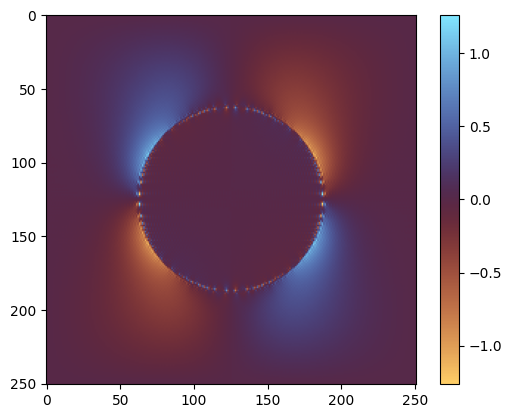

In [8]:
# --- solve for load cases & homogenize ---
if ndim == 3:
    E_list = [
        jnp.array(
            [[1, 0, 0], [0, 0, 0], [0, 0, 0]],
        ),  # E_xx
        jnp.array(
            [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
        ),  # E_yy
        jnp.array(
            [[0, 0, 0], [0, 0, 0], [0, 0, 1]],
        ),  # E_zz
        jnp.array(
            [[0, 1, 0], [1, 0, 0], [0, 0, 0]],
        ),  # 2E_xy
        jnp.array(
            [[0, 0, 0], [0, 0, 1], [0, 1, 0]],
        ),  # 2E_yz
        jnp.array(
            [[0, 0, 1], [1, 0, 0], [0, 0, 0]],
        ),  # 2E_xz
    ]

    homogenized_stiffness = jnp.zeros((6, 6))
    voigt_indices = [(0, 0), (1, 1), (2, 2), (0, 1), (1, 2), (0, 2)]

else:
    E_list = [
        jnp.array(
            [[1, 0], [0, 0]],
        ),  # E_xx
        jnp.array(
            [[0, 0], [0, 1]],
        ),  # E_yy
        jnp.array(
            [[0, 1], [1, 0]],
        ),  # 2E_xy
    ]

    homogenized_stiffness = jnp.zeros((2, 2))
    voigt_indices = [(0, 0), (1, 1), (0, 1)]


print("Starting homogenization...")
for i, E_voigt in enumerate(E_list):
    # Create the full E_macro field (broadcasts E_voigt)
    E_macro = make_field(dim=ndim, shape=(N, N), rank=2) + E_voigt

    # Solve the RVE problem
    eps_final = fixed_point_iteration(
        E_macro, eps_guess=E_macro, max_iter=200, tol=1e-8
    )

    # Compute the final stress field
    sig_final = op.ddot(C4, eps_final)

    # Homogenize (average over the volume)
    if ndim == 3:
        avg_stress = jnp.mean(sig_final, axis=(0, 1, 2))
    else:
        avg_stress = jnp.mean(sig_final, axis=(0, 1))

    # Store in Voigt notation
    for j, (row, col) in enumerate(voigt_indices):
        homogenized_stiffness = homogenized_stiffness.at[j, i].set(avg_stress[row, col])

print("Homogenized Stiffness (Voigt): \n", homogenized_stiffness)


plt.imshow(sig_final.at[:, :, 0, 0].get(), cmap="managua")
plt.colorbar()
plt.show()